# Introduction to Research module

## Roadmap

* Basic example
    * 1 pipeline with fixed parameters
         * creating research
         * running several repetitions of an experiment
         * defining results recording frequency aka execute='%n'
         * viewing research results
         * saving and loading research
* Runnung experiments with different parameters aka grid
    * 1 pipeline with variable parameters
         * creating and viewing grids
         * viewing filtered research results
* Reducing extra dataset loads
    * 1 pipeline with root and brunch + grid
* More complex execution strategies
    * 2 pipelines, train & test + function + root&brunch + grid
        * adding test pipeline
        * adding functions
* Cross-validation

* Performance
        * execution tasks managing
* Combining it all together
    * Super complex Research

## Basic example

In [1]:
import sys
sys.path.append('../../..')

import matplotlib
%matplotlib inline

from batchflow import Pipeline, B, C, V
from batchflow.opensets import MNIST
from batchflow.models.tf import VGG7, VGG16
from batchflow.research import Research, Option

In [2]:
BATCH_SIZE=64
ITERATIONS=10

In [3]:
mnist = MNIST()
train_root = mnist.train.p.run(BATCH_SIZE, shuffle=True, n_epochs=None, lazy=True)

In [4]:
    model_config={
        'inputs': dict(images={'shape': (28, 28, 1)},
                       labels={'classes': 10, 'transform': 'ohe', 'name': 'targets'}),
        'initial_block/inputs': 'images',
    }

    train_template = (Pipeline()
                .init_variable('loss', init_on_each_run=list)
                .init_model('dynamic', VGG7, 'conv', config=model_config)
                .to_array()
                .train_model('conv', fetches='loss',
                             feed_dict={'images': B('images'),
                                        'labels': B('labels')},
                             save_to=V('loss', mode='w'))
    )

    train_ppl = train_root + train_template

In [5]:
research = (Research()
            .add_pipeline(train_ppl, variables='loss', name='train'))

research.run(n_reps=4, n_iters=ITERATIONS, name='vgg7_research', bar=True)

Research vgg7_research_2 is starting...
Distributor has 4 jobs with 10 iterations. Totally: 40


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:59<00:00,  1.48s/it]


Each research is assigned with a unique name starting with *name* argument provided to *run*.
Results of the research and its log are saved in a folder with the same name in the working directory. 

In [6]:
import os
for name in os.listdir():
    print("{}\t{}".format('Dir' if os.path.isdir(name) else 'File', name))

Dir	.ipynb_checkpoints
File	1_Research_Introduction.ipynb
Dir	vgg7_research
Dir	vgg7_research_1
Dir	vgg7_research_2
Dir	vgg_layout_bias_research
Dir	vgg_layout_bias_research_1


In [7]:
results = research.load_results()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 9
Data columns (total 4 columns):
repetition    40 non-null int64
name          40 non-null object
loss          40 non-null float64
iteration     40 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.6+ KB


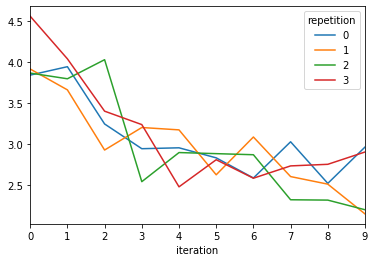

In [8]:
results.pivot(index='iteration', columns='repetition', values='loss').plot()

In [9]:
research = (Research()
            .add_pipeline(train_ppl, variables='loss', execute='%5', name='train'))
research.run(n_reps=4, n_iters=ITERATIONS, name='vgg7_research', bar=True)

Research vgg7_research_3 is starting...
Distributor has 4 jobs with 10 iterations. Totally: 40


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:57<00:00,  1.45s/it]


In [10]:
results = research.load_results()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 1
Data columns (total 4 columns):
repetition    8 non-null int64
name          8 non-null object
loss          8 non-null float64
iteration     8 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 320.0+ bytes


## Introducing grids

In [11]:
grid = (Option('layout', ['cna', 'can']) * Option('model', [VGG7, VGG16]) * Option('bias', [False])
        +  Option('layout', ['cna']) * Option('bias', [True]) * Option('model', [VGG7]))
list(grid.gen_configs())

[ConfigAlias({'layout': 'cna', 'model': 'VGG7', 'bias': 'False'}),
 ConfigAlias({'layout': 'cna', 'model': 'VGG16', 'bias': 'False'}),
 ConfigAlias({'layout': 'can', 'model': 'VGG7', 'bias': 'False'}),
 ConfigAlias({'layout': 'can', 'model': 'VGG16', 'bias': 'False'}),
 ConfigAlias({'layout': 'cna', 'bias': 'True', 'model': 'VGG7'})]

In [12]:
model_config.update({
    'body/block/layout': C('layout'),
    'common/conv/use_bias': C('bias'),
})


# For reference: previous train_template definition 
#     train_template = (Pipeline()
#                 .init_variable('loss', init_on_each_run=list)
#                 .init_model('dynamic', VGG7, 'conv', config=model_config) # Note model class defined explicitly
#                 .to_array()
#                 .train_model('conv', fetches='loss',
#                              feed_dict={'images': B('images'),
#                                         'labels': B('labels')},
#                              save_to=V('loss', mode='w'))
#     )

train_template = (Pipeline()
            .init_variable('loss', init_on_each_run=list)
            .init_model('dynamic', C('model'), 'conv', config=model_config) # Model class defined via named expression
            .to_array()
            .train_model('conv', fetches='loss',
                         feed_dict={'images': B('images'),
                                    'labels': B('labels')},
                         save_to=V('loss', mode='w'))
)

train_ppl = train_root + train_template

In [13]:
research = (Research()
            .add_pipeline(train_ppl, variables='loss', name='train')
            .add_grid(grid))

research.run(n_reps=2, n_iters=ITERATIONS, name='vgg_layout_bias_research', bar=True)


Research vgg_layout_bias_research_2 is starting...
Distributor has 10 jobs with 10 iterations. Totally: 100


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.67s/it]


In [14]:
results = research.load_results()
results.head()

,bias,iteration,layout,loss,model,name,repetition
0,False,0,cna,4.504781,VGG7,train,0
1,False,1,cna,3.670130,VGG7,train,0
2,False,2,cna,3.395448,VGG7,train,0
3,False,3,cna,2.924818,VGG7,train,0
4,False,4,cna,2.628530,VGG7,train,0


#### Controlling *load_results* output

In [15]:
results = research.load_results(use_alias=True)
results.head()

,repetition,name,loss,iteration,config
0,0,train,4.504781,0,bias_False-layout_cna-model_VGG7
1,0,train,3.670130,1,bias_False-layout_cna-model_VGG7
2,0,train,3.395448,2,bias_False-layout_cna-model_VGG7
3,0,train,2.924818,3,bias_False-layout_cna-model_VGG7
4,0,train,2.628530,4,bias_False-layout_cna-model_VGG7


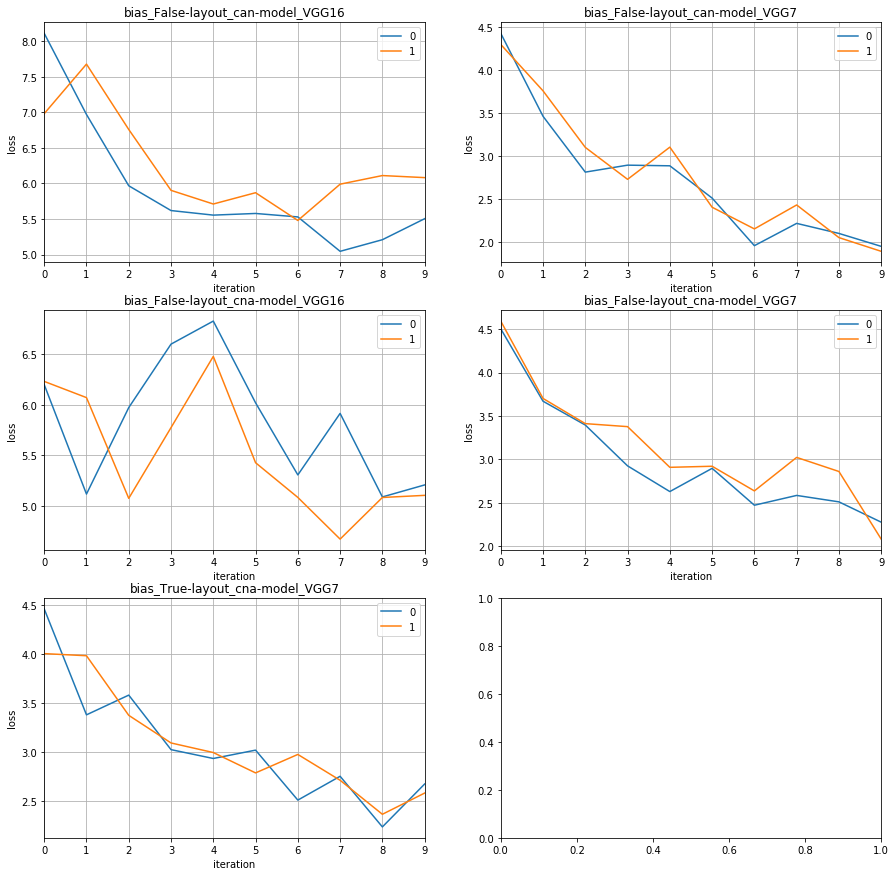

In [16]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for i, (config, df) in enumerate(results.groupby('config')):
    x, y = i//2, i%2
    df.pivot(index='iteration', columns='repetition', values='loss').plot(ax=ax[x, y])
    ax[x, y].set_title(config)
    ax[x, y].set_xlabel('iteration')
    ax[x, y].set_ylabel('loss')
    ax[x, y].grid(True)
    ax[x, y].legend()

In [17]:
research.load_results(aliases={'model': 'VGG7'}).head()

,bias,iteration,layout,loss,model,name,repetition
0,False,0,cna,4.504781,VGG7,train,0
1,False,1,cna,3.670130,VGG7,train,0
2,False,2,cna,3.395448,VGG7,train,0
3,False,3,cna,2.924818,VGG7,train,0
4,False,4,cna,2.628530,VGG7,train,0


In [18]:
research.load_results(configs={'model': VGG7}).head()

,bias,iteration,layout,loss,model,name,repetition
0,False,0,cna,4.504781,VGG7,train,0
1,False,1,cna,3.670130,VGG7,train,0
2,False,2,cna,3.395448,VGG7,train,0
3,False,3,cna,2.924818,VGG7,train,0
4,False,4,cna,2.628530,VGG7,train,0


In [19]:
research.load_results(repetitions=1, iterations=[0,9]).head()

,bias,iteration,layout,loss,model,name,repetition
0,False,0,cna,4.593832,VGG7,train,1
1,False,9,cna,2.080465,VGG7,train,1
0,False,0,cna,6.230906,VGG16,train,1
1,False,9,cna,5.105008,VGG16,train,1
0,False,0,can,4.300362,VGG7,train,1


### Loading saved researches 

In [20]:
for name in os.listdir():
    print("{}\t{}".format('Dir' if os.path.isdir(name) else 'File', name))

Dir	.ipynb_checkpoints
File	1_Research_Introduction.ipynb
Dir	vgg7_research
Dir	vgg7_research_1
Dir	vgg7_research_2
Dir	vgg7_research_3
Dir	vgg_layout_bias_research
Dir	vgg_layout_bias_research_1
Dir	vgg_layout_bias_research_2


In [21]:
import json
import pprint
with open(os.path.join('vgg_layout_bias_research', 'description', 'research.json')) as f:
    pprint.pprint(json.load(f))

{'bar': True,
 'branches': 1,
 'executables': {'train': '<batchflow.research.research.Executable object at '
                          '0x000002582973E7F0>'},
 'framework': 'tf',
 'gpu': [],
 'grid_config': [[{'layout': ['cna', 'can']},
                  {'model': ["<class 'batchflow.models.tf.vgg.VGG7'>",
                             "<class 'batchflow.models.tf.vgg.VGG16'>"]},
                  {'bias': [False]}],
                 [{'layout': ['cna']},
                  {'bias': [True]},
                  {'model': ["<class 'batchflow.models.tf.vgg.VGG7'>"]}]],
 'initial_name': 'vgg_layout_bias_research',
 'loaded': False,
 'n_iters': 1000,
 'n_reps': 2,
 'n_splits': None,
 'name': 'vgg_layout_bias_research',
 'shuffle': False,
 'timeout': 5,
 'trails': 2,
 'worker_class': "<class 'batchflow.research.workers.PipelineWorker'>",
 'workers': 1}


In [22]:
loaded_research = Research.load('vgg_layout_bias_research')

In [25]:
loaded_research.describe()

{'bar': True,
 'branches': 1,
 'executables': OrderedDict([('train',
                              <batchflow.research.research.Executable object at 0x0000029F34373CF8>)]),
 'framework': 'tf',
 'gpu': [],
 'grid_config': Grid([[{'layout': ['cna', 'can']}, {'model': ['VGG7', 'VGG16']}, {'bias': ['False']}], [{'layout': ['cna']}, {'bias': ['True']}, {'model': ['VGG7']}]]),
 'initial_name': 'vgg_layout_bias_research',
 'loaded': True,
 'n_iters': 1000,
 'n_reps': 2,
 'n_splits': None,
 'name': 'vgg_layout_bias_research_3',
 'shuffle': False,
 'timeout': 5,
 'trails': 2,
 'worker_class': <class 'batchflow.research.workers.PipelineWorker'>,
 'workers': 1}


In [23]:
loaded_research.run(n_reps=4, n_iters=ITERATIONS, name='vgg7_research_1_load', bar=True)

Research vgg_layout_bias_research_3 is starting...
Distributor has 10 jobs with 1000 iterations. Totally: 10000


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:34<00:00, 12.28it/s]


In [24]:
loaded_research.load_results().sample(10)

,bias,iteration,layout,loss,model,name,repetition
253,False,253,can,0.093732,VGG16,train,1
34,False,34,can,0.663319,VGG7,train,1
736,True,736,cna,0.034324,VGG7,train,1
869,False,869,can,0.016900,VGG7,train,1
430,False,430,cna,1.153190,VGG16,train,0
554,False,554,can,0.045754,VGG16,train,1
737,False,737,cna,0.089901,VGG7,train,0
385,False,385,can,0.030941,VGG16,train,0
8,False,8,cna,6.185194,VGG16,train,0
878,False,878,cna,0.106734,VGG7,train,1
